# Credit Risk Scorecard: End-to-End Machine Learning Pipeline

## 📋 Table of Contents

1. [**Executive Summary**](#executive-summary)
2. [**Environment Setup**](#1-environment-setup)
3. [**Data Loading & Exploration**](#2-data-loading--exploration)
4. [**Data Preprocessing**](#3-data-preprocessing)
5. [**Feature Engineering**](#4-feature-engineering)
6. [**Model Development**](#5-model-development)
7. [**Model Evaluation & Comparison**](#6-model-evaluation--comparison)
8. [**Credit Scorecard Creation**](#7-credit-scorecard-creation)
9. [**Business Impact Analysis**](#8-business-impact-analysis)
10. [**Production Deployment Guide**](#9-production-deployment-guide)

---

## Executive Summary

This notebook develops a **production-ready credit risk model** using industry-standard techniques:
- **Weight of Evidence (WOE)** and **Information Value (IV)** for feature selection
- **Logistic Regression** for interpretability and regulatory compliance
- **Advanced ML models** (LightGBM, XGBoost) for performance benchmarking
- **Business-oriented scorecard** with clear risk segmentation

**Key Results:**
- Model AUC: 0.72-0.76 (depending on approach)
- Expected portfolio loss reduction: ~43%
- Clear risk segmentation with 5 customer tiers
- Production-ready monitoring framework

**Estimated Runtime:** ~5-10 minutes (depending on system)

In [213]:
# Track notebook execution time
import time
notebook_start_time = time.time()

def print_section_time(section_name, start_time):
    """Helper function to print execution time for each section"""
    elapsed = time.time() - start_time
    print(f"\n{section_name} completed in {elapsed:.2f} seconds")
    #print(f"\nCurrent Time is {time.time()}")
    return time.time()

## 1. Environment Setup

Loading all required libraries and setting up the environment for reproducible results.

In [216]:
section_start = time.time()

# System
import os
import warnings
import sys
from pathlib import Path

In [218]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [220]:
# Machine Learning
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [222]:
# Advanced ML libraries (optional - will check availability)
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print(" LightGBM not installed. Install with: pip install lightgbm")

In [233]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [224]:
# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Environment setup complete")
print(f"Python: {sys.version.split()[0]}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

print_section_time("Environment Setup", section_start)

Environment setup complete
Python: 3.12.7
Pandas: 2.2.3
NumPy: 1.26.4
Scikit-learn: 1.5.2

Environment Setup completed in 6.10 seconds


1758239052.0345569

## 2. Data Loading & Exploration

### 2.1 Load Dataset

In [229]:
section_start = time.time()

# Authenticate

api = KaggleApi()
api.authenticate()

# Download to a specific folder
api.dataset_download_files('ranadeep/credit-risk-dataset', 
                          path='./', 
                          unzip=True)

# Load the CSV
df = pd.read_csv('./loan.csv')

Dataset URL: https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset


In [235]:
# If downloading dataset
# Flexible file loading
#DATA_PATH = 'loan.csv'  # Update this path as needed
#
## Check if file exists
#if not os.path.exists(DATA_PATH):
#    print(f"Error: {DATA_PATH} not found!")
#    print("Please ensure the loan.csv file is in the current directory or update DATA_PATH")
#else:
#    df = pd.read_csv(DATA_PATH)
#    print(f"Data loaded successfully: {df.shape[0]:,} rows × {df.shape[1]} columns")#

### 2.2 Initial Data Exploration

In [21]:
# Basic information
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage().sum() / 1024**2:.1f} MB")
print(f"\nData Types:")
print(df.dtypes.value_counts())

DATASET OVERVIEW
Shape: (887379, 74)
Memory Usage: 501.0 MB

Data Types:
float64    49
object     23
int64       2
Name: count, dtype: int64


In [22]:
# Missing values summary
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)

print(f"\nMissing Values Summary:")
print(f"Columns with missing values: {len(missing_summary)}")
print(f"Columns with >90% missing: {len(missing_summary[missing_summary['Missing_Percent'] > 90])}")
print(f"Columns with >50% missing: {len(missing_summary[missing_summary['Missing_Percent'] > 50])}")

# Sample of data
print("\n Data Sample:")
df.head(5)


Missing Values Summary:
Columns with missing values: 40
Columns with >90% missing: 17
Columns with >50% missing: 21

 Data Sample:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0000,5000.0000,4975.0000,36 months,10.6500,162.8700,B,B2,NaN,10+ years,RENT,24000.0000,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.6500,0.0000,Jan-1985,1.0000,NaN,NaN,3.0000,0.0000,13648.0000,83.7000,9.0000,f,0.0000,0.0000,5861.0714,5831.7800,5000.0000,861.0700,0.0000,0.0000,0.0000,Jan-2015,171.6200,NaN,Jan-2016,0.0000,NaN,1.0000,INDIVIDUAL,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0000,2500.0000,2500.0000,60 months,15.2700,59.8300,C,C4,Ryder,< 1 year,RENT,30000.0000,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.0000,0.0000,Apr-1999,5.0000,NaN,NaN,3.0000,0.0000,1687.0000,9.4000,4.0000,f,0.0000,0.0000,1008.7100,1008.7100,456.4600,435.1700,0.0000,117.0800,1.1100,Apr-2013,119.6600,NaN,Sep-2013,0.0000,NaN,1.0000,INDIVIDUAL,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0000,2400.0000,2400.0000,36 months,15.9600,84.3300,C,C5,NaN,10+ years,RENT,12252.0000,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.7200,0.0000,Nov-2001,2.0000,NaN,NaN,2.0000,0.0000,2956.0000,98.5000,10.0000,f,0.0000,0.0000,3003.6536,3003.6500,2400.0000,603.6500,0.0000,0.0000,0.0000,Jun-2014,649.9100,NaN,Jan-2016,0.0000,NaN,1.0000,INDIVIDUAL,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0000,10000.0000,10000.0000,36 months,13.4900,339.3100,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0000,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.0000,0.0000,Feb-1996,1.0000,35.0000,NaN,10.0000,0.0000,5598.0000,21.0000,37.0000,f,0.0000,0.0000,12226.3022,12226.3000,10000.0000,2209.3300,16.9700,0.0000,0.0000,Jan-2015,357.4800,NaN,Jan-2015,0.0000,NaN,1.0000,INDIVIDUAL,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0000,3000.0000,3000.0000,60 months,12.6900,67.7900,B,B5,University Medical Group,1 year,RENT,80000.0000,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.9400,0.0000,Jan-1996,0.0000,38.0000,NaN,15.0000,0.0000,27783.0000,53.9000,38.0000,f,766.9000,766.9000,3242.1700,3242.1700,2233.1000,1009.0700,0.0000,0.0000,0.0000,Jan-2016,67.7900,Feb-2016,Jan-2016,0.0000,NaN,1.0000,INDIVIDUAL,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.3 Target Variable Creation

Creating a binary target variable from loan_status:

In [27]:
# Analyze loan_status distribution
print("Loan Status Distribution:")
print(df['loan_status'].value_counts())

Loan Status Distribution:
loan_status
Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64


In [29]:
# Create target variable
def create_target(loan_status):
    """Map loan status to binary target (0=Good, 1=Bad)"""
    bad_status = ['Charged Off', 'Default', 'Late (31-120 days)', 
                  'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off']
    good_status = ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid']
    
    if loan_status in bad_status:
        return 1  # Bad
    elif loan_status in good_status:
        return 0  # Good
    else:
        return None  # Exclude

In [31]:
df['target'] = df['loan_status'].apply(create_target)
df = df.dropna(subset=['target'])
df['target'] = df['target'].astype(int)

# Target distribution
target_dist = df['target'].value_counts()
print(f"\nTarget Distribution:")
print(f"Good loans (0): {target_dist[0]:,} ({target_dist[0]/len(df)*100:.1f}%)")
print(f"Bad loans (1):  {target_dist[1]:,} ({target_dist[1]/len(df)*100:.1f}%)")
print(f"Imbalance ratio: {target_dist[0]/target_dist[1]:.1f}:1")

print_section_time("Data Loading & Exploration", section_start)


Target Distribution:
Good loans (0): 811,490 (93.0%)
Bad loans (1):  61,176 (7.0%)
Imbalance ratio: 13.3:1

Data Loading & Exploration completed in 10.25 seconds


1758232673.078159

## 3. Data Preprocessing

### 3.1 Remove Leakage and Irrelevant Features

In [33]:
section_start = time.time()

# Define columns to drop
drop_cols = {
    'identifiers': ['id', 'member_id', 'url'],
    'target_related': ['loan_status'],
    'text_fields': ['desc', 'emp_title', 'title', 'zip_code'],
    'policy': ['policy_code'],  # Almost always 1
    'joint_apps': ['annual_inc_joint', 'dti_joint', 'verification_status_joint'],  # Rare
    'future_info': ['next_pymnt_d', 'last_pymnt_d', 'last_credit_pull_d',
                    'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
                    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
                    'recoveries', 'collection_recovery_fee'],
    'high_missing': ['mths_since_last_major_derog']  # >70% missing
}

# Flatten the dictionary
all_drop_cols = [col for cols in drop_cols.values() for col in cols]

# Drop columns that exist
cols_to_drop = [col for col in all_drop_cols if col in df.columns]
df = df.drop(columns=cols_to_drop)

print(f"Dropped {len(cols_to_drop)} columns")
print(f"Remaining features: {df.shape[1] - 1} (excluding target)")

Dropped 25 columns
Remaining features: 49 (excluding target)


### 3.2 Handle Date Features

In [36]:
# Convert date columns and create credit history length
if 'issue_d' in df.columns and 'earliest_cr_line' in df.columns:
    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
    
    # Create credit history length in years
    df['credit_history_length'] = (df['issue_d'] - df['earliest_cr_line']).dt.days / 365.25
    
    # Drop original date columns
    df = df.drop(columns=['issue_d', 'earliest_cr_line'])
    print("Created credit_history_length feature")

Created credit_history_length feature


### 3.3 Handle Missing Values

In [39]:
# Analyze missing values
missing_analysis = pd.DataFrame({
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_analysis = missing_analysis[missing_analysis['Missing_Percent'] > 0].sort_values('Missing_Percent', ascending=False)

# Drop columns with >95% missing
high_missing_cols = missing_analysis[missing_analysis['Missing_Percent'] > 95].index.tolist()
if high_missing_cols:
    df = df.drop(columns=high_missing_cols)
    print(f"Dropped {len(high_missing_cols)} columns with >95% missing values")

Dropped 14 columns with >95% missing values


In [41]:
# Impute remaining missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'target']
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Impute numeric columns with median
for col in numeric_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

# Impute categorical columns with mode
for col in categorical_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
        df[col].fillna(mode_val, inplace=True)

print(f"Missing value imputation complete")
print(f"Remaining missing values: {df.isnull().sum().sum()}")

print_section_time("Data Preprocessing", section_start)

Missing value imputation complete
Remaining missing values: 0

Data Preprocessing completed in 4.64 seconds


## 4. Feature Engineering

#### 4.1.1 Create Domain-Specific Features

In [43]:
section_start = time.time()

print("Creating domain-specific features...")

# 1. Loan burden ratio
if 'loan_amnt' in df.columns and 'annual_inc' in df.columns:
    df['loan_burden'] = df['loan_amnt'] / (df['annual_inc'] + 1)
    print("✓ Created loan_burden")

# 2. Payment to income ratio
if 'installment' in df.columns and 'annual_inc' in df.columns:
    df['payment_to_income'] = df['installment'] / (df['annual_inc'] / 12 + 1)
    print("✓ Created payment_to_income")

# 3. Credit utilization categories
if 'revol_util' in df.columns:
    df['high_credit_util'] = (df['revol_util'] > 70).astype(int)
    df['zero_balance'] = (df['revol_util'] == 0).astype(int)
    print("✓ Created credit utilization features")

# 4. Derogatory marks
derog_cols = ['pub_rec', 'delinq_2yrs', 'collections_12_mths_ex_med']
available_derog = [col for col in derog_cols if col in df.columns]
if available_derog:
    df['total_derog'] = df[available_derog].sum(axis=1)
    df['has_derog'] = (df['total_derog'] > 0).astype(int)
    print("✓ Created derogatory mark features")

# 5. Account age features
if 'total_acc' in df.columns and 'credit_history_length' in df.columns:
    df['avg_account_age'] = df['credit_history_length'] / (df['total_acc'] + 1)
    print("✓ Created account age features")

# Drop original features that were combined
if 'loan_burden' in df.columns and 'loan_amnt' in df.columns:
    df = df.drop(columns=['loan_amnt', 'dti'], errors='ignore')

print(f"\nFeature engineering complete. Total features: {df.shape[1] - 1}")

Creating domain-specific features...
✓ Created loan_burden
✓ Created payment_to_income
✓ Created credit utilization features
✓ Created derogatory mark features
✓ Created account age features

Feature engineering complete. Total features: 39


#### 4.1.2 Advanced Feature Engineering Part 1

In [47]:
# Advanced Feature Engineering Part 1

# Check what columns we have available
print("Available numeric columns:")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print([col for col in numeric_cols if not col.endswith('_bin') and col != 'target'])

# Store original feature count
original_features = df.shape[1]

Available numeric columns:
['funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'credit_history_length', 'loan_burden', 'payment_to_income', 'high_credit_util', 'zero_balance', 'total_derog', 'has_derog', 'avg_account_age']


In [49]:
# 1. Interaction Features (using only available columns)
if 'annual_inc' in df.columns and 'total_rev_hi_lim' in df.columns:
    df['income_to_credit_limit'] = df['annual_inc'] / (df['total_rev_hi_lim'] + 1)

# Skip credit_utilization_stress since dti is dropped
# Instead use revolving utilization with installment
if 'installment' in df.columns:
    df['payment_to_income'] = df['installment'] / (df['annual_inc'] / 12 + 1)
    df['installment_rev_ratio'] = df['installment'] / (df['total_rev_hi_lim'] + 1)

if 'total_acc' in df.columns and 'credit_history_length' in df.columns:
    df['credit_line_age_ratio'] = df['total_acc'] / (df['credit_history_length'] + 1)

In [51]:
# 2. Non-linear transformations
df['log_annual_inc'] = np.log1p(df['annual_inc'])
df['sqrt_total_rev_hi_lim'] = np.sqrt(df['total_rev_hi_lim'])
df['int_rate_squared'] = df['int_rate'] ** 2

In [53]:
# 3. Domain-specific ratios (only if columns exist)
if 'revol_bal' in df.columns:
    df['revolving_to_total_bal'] = df['revol_bal'] / (df['tot_cur_bal'] + 1)
    
df['inquiries_per_credit_year'] = df['inq_last_6mths'] / (df['credit_history_length'] + 1)

In [55]:
# 4. Additional features based on available columns
if 'pub_rec' in df.columns and 'delinq_2yrs' in df.columns:
    df['total_derog'] = df['pub_rec'] + df['delinq_2yrs']
    
if 'acc_now_delinq' in df.columns:
    df['has_current_delinq'] = (df['acc_now_delinq'] > 0).astype(int)

In [57]:
# Count features created
new_feature_count = df.shape[1] - original_features
print(f"\nCreated {new_feature_count} new engineered features")

# List the new features that were actually created
new_features = []
possible_features = ['income_to_credit_limit', 'payment_to_income', 'installment_rev_ratio',
                    'credit_line_age_ratio', 'log_annual_inc', 'sqrt_total_rev_hi_lim',
                    'int_rate_squared', 'revolving_to_total_bal', 'inquiries_per_credit_year',
                    'total_derog', 'has_current_delinq']

print("New features added:")
for feat in possible_features:
    if feat in df.columns:
        new_features.append(feat)
        print(f"  • {feat}")


Created 9 new engineered features
New features added:
  • income_to_credit_limit
  • payment_to_income
  • installment_rev_ratio
  • credit_line_age_ratio
  • log_annual_inc
  • sqrt_total_rev_hi_lim
  • int_rate_squared
  • revolving_to_total_bal
  • inquiries_per_credit_year
  • total_derog
  • has_current_delinq


#### 4.1.3 Advanced Feature Engineering Part 2

In [60]:
# Advanced Feature Engineering Part 2 - Comprehensive Feature Creation

# Store the starting number of features
start_features = df.shape[1]

In [66]:
# 1. DOMAIN-SPECIFIC CREDIT RISK FEATURES
print("\nCreating Domain-Specific Features...")

# Credit utilization categories (non-linear risk relationship)
if 'revol_util' in df.columns:
    df['credit_util_category'] = pd.cut(df['revol_util'], 
                                        bins=[-np.inf, 0, 30, 50, 70, 90, 100],
                                        labels=['no_usage', 'low', 'moderate', 'high', 'very_high', 'maxed_out'])
    df['is_credit_maxed'] = (df['revol_util'] > 95).astype(int)
    df['is_zero_balance'] = (df['revol_bal'] == 0).astype(int)

# Debt concentration
if 'installment' in df.columns and 'tot_cur_bal' in df.columns and 'revol_bal' in df.columns:
    df['installment_to_total_debt'] = df['installment'] / (df['tot_cur_bal'] + df['revol_bal'] + 1)
    df['revolving_debt_ratio'] = df['revol_bal'] / (df['tot_cur_bal'] + 1)

# Payment capacity indicators
if 'installment' in df.columns and 'annual_inc' in df.columns and 'revol_bal' in df.columns:
    df['monthly_debt_service'] = df['installment'] + (df['revol_bal'] * 0.02)  # Assume 2% min payment
    df['debt_service_ratio'] = df['monthly_debt_service'] / (df['annual_inc'] / 12 + 1)
    df['disposable_income'] = (df['annual_inc'] / 12) - df['installment']
    df['payment_buffer'] = df['disposable_income'] / (df['installment'] + 1)


Creating Domain-Specific Features...


In [68]:
# 2. BEHAVIORAL RISK INDICATORS
print("Creating Behavioral Risk Indicators...")

# Credit seeking behavior
if 'inq_last_6mths' in df.columns and 'open_acc' in df.columns and 'total_acc' in df.columns:
    df['recent_credit_hungry'] = ((df['inq_last_6mths'] > 2) & (df['open_acc'] > df['total_acc'] * 0.7)).astype(int)
    df['inquiry_intensity'] = df['inq_last_6mths'] / (df['credit_history_length'] + 1) * 12  # Annualized

# Account management patterns
if 'open_acc' in df.columns and 'total_acc' in df.columns:
    df['account_diversity'] = 1 - (df['open_acc'] / (df['total_acc'] + 1))**2  # Simpson diversity index
    df['credit_line_utilization'] = df['tot_cur_bal'] / (df['total_rev_hi_lim'] + 1)
    df['avg_account_age'] = df['credit_history_length'] / (df['total_acc'] + 1)

# Delinquency patterns
if 'pub_rec' in df.columns and 'delinq_2yrs' in df.columns and 'collections_12_mths_ex_med' in df.columns:
    df['total_derog_marks'] = df['pub_rec'] + df['delinq_2yrs'] + df['collections_12_mths_ex_med']
    df['derog_per_year'] = df['total_derog_marks'] / (df['credit_history_length'] + 1)
    df['clean_history'] = (df['total_derog_marks'] == 0).astype(int)

Creating Behavioral Risk Indicators...


In [74]:
# 3. ADVANCED RATIOS AND TRANSFORMATIONS
print("Creating Advanced Ratios...")

# Non-linear transformations for key variables
df['log_total_rev_hi_lim'] = np.log1p(df['total_rev_hi_lim'])
df['sqrt_annual_inc'] = np.sqrt(df['annual_inc'])
df['int_rate_cubed'] = df['int_rate'] ** 3
df['log_loan_to_inc'] = np.log1p(df['loan_burden'])

# Polynomial features for critical predictors
if 'revol_util' in df.columns:
    df['int_rate_x_loan_burden'] = df['int_rate'] * df['loan_burden']
    df['revol_util_squared'] = df['revol_util'] ** 2
    df['credit_age_x_inquiries'] = df['credit_history_length'] * df['inq_last_6mths']

Creating Advanced Ratios...


In [78]:
# 4. INTERACTION FEATURES
print("Creating Interaction Features...")

# Risk multiplication effects
df['high_rate_high_burden'] = ((df['int_rate'] > df['int_rate'].quantile(0.75)) & 
                                (df['loan_burden'] > df['loan_burden'].quantile(0.75))).astype(int)

df['low_income_high_debt'] = ((df['annual_inc'] < df['annual_inc'].quantile(0.25)) & 
                               (df['tot_cur_bal'] > df['tot_cur_bal'].quantile(0.75))).astype(int)

# Verification impact
if 'verification_status' in df.columns:
    df['unverified_high_amount'] = ((df['verification_status'] == 'Not Verified') & 
                                     (df['loan_burden'] > df['loan_burden'].median())).astype(int)



Creating Interaction Features...


In [80]:
# Count features created
new_features = df.shape[1] - start_features
print(f"\nCreated {new_features} new features in Part 2!")
print(f"Total features now: {df.shape[1]}")


Created 26 new features in Part 2!
Total features now: 75


#### 4.1.4 Advanced Feature Engineering Part 3

In [82]:
# Advanced Feature Engineering Part 3 - Statistical and Composite Features

# Store starting features
start_features_p3 = df.shape[1]

# 1. STATISTICAL FEATURES
print("Creating Statistical Features...")

# Create percentile ranks for continuous features
continuous_features = ['annual_inc', 'int_rate', 'revol_util', 'tot_cur_bal', 'credit_history_length']
for feat in continuous_features:
    if feat in df.columns:
        df[f'{feat}_percentile'] = df[feat].rank(pct=True)

# Z-scores for outlier detection
for feat in ['annual_inc', 'tot_cur_bal']:
    if feat in df.columns:
        mean = df[feat].mean()
        std = df[feat].std()
        df[f'{feat}_zscore'] = np.abs((df[feat] - mean) / std)
        df[f'{feat}_is_outlier'] = (df[f'{feat}_zscore'] > 3).astype(int)

Creating Statistical Features...


In [84]:
# 2. BINNED INTERACTIONS
print("Creating Binned Interactions...")

# Create risk segments based on multiple features
df['risk_segment'] = 0
df.loc[(df['int_rate'] > df['int_rate'].median()) & 
       (df['loan_burden'] > df['loan_burden'].median()), 'risk_segment'] = 1
df.loc[(df['int_rate'] > df['int_rate'].quantile(0.75)) & 
       (df['loan_burden'] > df['loan_burden'].quantile(0.75)), 'risk_segment'] = 2

# Income-based risk tiers
if 'annual_inc' in df.columns and 'int_rate' in df.columns:
    income_bins = pd.qcut(df['annual_inc'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    rate_bins = pd.qcut(df['int_rate'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    df['income_rate_tier'] = income_bins.astype(str) + '_' + rate_bins.astype(str)

Creating Binned Interactions...


In [86]:
# 3. PURPOSE-SPECIFIC FEATURES
print("Creating Purpose-Specific Features...")

if 'purpose' in df.columns:
    # High-risk purposes
    high_risk_purposes = ['small_business', 'vacation', 'wedding', 'moving']
    df['is_high_risk_purpose'] = df['purpose'].isin(high_risk_purposes).astype(int)
    
    # Debt consolidation specific
    df['debt_consolidation_high_rate'] = ((df['purpose'] == 'debt_consolidation') & 
                                          (df['int_rate'] > df['int_rate'].median())).astype(int)

Creating Purpose-Specific Features...


In [88]:
# 4.. TEMPORAL PATTERNS
print("Creating Temporal Features...")

# Credit velocity
if 'open_acc' in df.columns and 'credit_history_length' in df.columns:
    df['accounts_per_year'] = df['open_acc'] / (df['credit_history_length'] + 1)
    df['recent_account_opening_rate'] = df['inq_last_6mths'] / 6  # Monthly rate

# Maturity indicators
df['is_credit_mature'] = (df['credit_history_length'] > 10).astype(int)
df['is_credit_young'] = (df['credit_history_length'] < 3).astype(int)

Creating Temporal Features...


In [90]:
# 5.. EXTREME VALUE INDICATORS
print("Creating Extreme Value Indicators...")

# Flag extreme values that might indicate risk
df['extreme_high_income'] = (df['annual_inc'] > df['annual_inc'].quantile(0.99)).astype(int)
df['extreme_low_income'] = (df['annual_inc'] < df['annual_inc'].quantile(0.01)).astype(int)
df['extreme_high_debt'] = (df['tot_cur_bal'] > df['tot_cur_bal'].quantile(0.95)).astype(int)

Creating Extreme Value Indicators...


In [92]:
# 6.. COMPOSITE RISK SCORES
print("Creating Composite Risk Scores...")

# Create a simple risk score based on multiple factors
df['composite_risk_score'] = (
    (df['int_rate'] / df['int_rate'].max()) * 0.3 +
    (df['loan_burden'] / df['loan_burden'].max()) * 0.2 +
    (df['revol_util'] / 100) * 0.2 +
    (df['inq_last_6mths'] / df['inq_last_6mths'].max()) * 0.15 +
    ((df['delinq_2yrs'] > 0).astype(int)) * 0.15
)

Creating Composite Risk Scores...


In [94]:
# Count features created
new_features_p3 = df.shape[1] - start_features_p3
total_advanced_features = df.shape[1] - original_features
print(f"\nCreated {new_features_p3} new features in Part 3!")
print(f"Total advanced features created: {total_advanced_features}")
print(f"Total features now: {df.shape[1]}")

# List all new features created across all parts
print("\nComplete list of advanced features created:")
advanced_feature_list = [col for col in df.columns if col not in df.columns[:original_features]]
for i, feat in enumerate(advanced_feature_list, 1):
    print(f"{i:3d}. {feat}")


Created 21 new features in Part 3!
Total advanced features created: 56
Total features now: 96

Complete list of advanced features created:
  1. income_to_credit_limit
  2. installment_rev_ratio
  3. credit_line_age_ratio
  4. log_annual_inc
  5. sqrt_total_rev_hi_lim
  6. int_rate_squared
  7. revolving_to_total_bal
  8. inquiries_per_credit_year
  9. has_current_delinq
 10. credit_util_category
 11. is_credit_maxed
 12. is_zero_balance
 13. installment_to_total_debt
 14. revolving_debt_ratio
 15. monthly_debt_service
 16. debt_service_ratio
 17. disposable_income
 18. payment_buffer
 19. recent_credit_hungry
 20. inquiry_intensity
 21. account_diversity
 22. credit_line_utilization
 23. total_derog_marks
 24. derog_per_year
 25. clean_history
 26. log_total_rev_hi_lim
 27. sqrt_annual_inc
 28. int_rate_cubed
 29. log_loan_to_inc
 30. int_rate_x_loan_burden
 31. revol_util_squared
 32. credit_age_x_inquiries
 33. high_rate_high_burden
 34. low_income_high_debt
 35. unverified_high_amo

#### 4.1.5 Feature Selection and Imprtance Analysis

In [98]:
# Feature Selection and Importance Analysis
# Calculate Information Value for all new features

# Get numeric features only
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f != 'target' and not f.endswith('_bin')]

print(f"Total numeric features to analyze: {len(numeric_features)}")

Total numeric features to analyze: 82


In [100]:
# Calculate mutual information
print("\nCalculating mutual information scores...")
mi_scores = mutual_info_classif(df[numeric_features].fillna(0), df['target'], random_state=42)
mi_df = pd.DataFrame({'feature': numeric_features, 'mi_score': mi_scores})
mi_df = mi_df.sort_values('mi_score', ascending=False)

print("\nTop 30 features by Mutual Information:")
print(mi_df.head(30).to_string())


Calculating mutual information scores...

Top 30 features by Mutual Information:
                         feature  mi_score
76              is_credit_mature    0.1522
51                 clean_history    0.1442
8         mths_since_last_record    0.1144
7         mths_since_last_delinq    0.0647
26                     has_derog    0.0520
73  debt_consolidation_high_rate    0.0493
23              high_credit_util    0.0428
14               last_pymnt_amnt    0.0391
2                       int_rate    0.0298
33              int_rate_squared    0.0295
63           int_rate_percentile    0.0293
54                int_rate_cubed    0.0291
6                 inq_last_6mths    0.0284
75   recent_account_opening_rate    0.0274
71                  risk_segment    0.0186
3                    installment    0.0173
56        int_rate_x_loan_burden    0.0133
9                       open_acc    0.0098
0                    funded_amnt    0.0087
81          composite_risk_score    0.0086
22             

In [101]:
# Select top features
top_features = mi_df.head(50)['feature'].tolist()

# Identify which are new features vs original
original_features_list = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 
                         'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 
                         'verification_status', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 
                         'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
                         'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
                         'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                         'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 
                         'tot_cur_bal', 'total_rev_hi_lim', 'credit_history_length', 'loan_burden']

new_top_features = [f for f in top_features if f not in original_features_list]

print(f"\nTop new engineered features (from top 50):")
for i, feat in enumerate(new_top_features[:20], 1):
    score = mi_df[mi_df['feature'] == feat]['mi_score'].values[0]
    print(f"{i:2d}. {feat:<35} MI Score: {score:.4f}")


Top new engineered features (from top 50):
 1. is_credit_mature                    MI Score: 0.1522
 2. clean_history                       MI Score: 0.1442
 3. mths_since_last_record              MI Score: 0.1144
 4. mths_since_last_delinq              MI Score: 0.0647
 5. has_derog                           MI Score: 0.0520
 6. debt_consolidation_high_rate        MI Score: 0.0493
 7. high_credit_util                    MI Score: 0.0428
 8. last_pymnt_amnt                     MI Score: 0.0391
 9. int_rate_squared                    MI Score: 0.0295
10. int_rate_percentile                 MI Score: 0.0293
11. int_rate_cubed                      MI Score: 0.0291
12. recent_account_opening_rate         MI Score: 0.0274
13. risk_segment                        MI Score: 0.0186
14. int_rate_x_loan_burden              MI Score: 0.0133
15. composite_risk_score                MI Score: 0.0086
16. payment_to_income                   MI Score: 0.0076
17. high_rate_high_burden               MI S

In [102]:
# Update features_to_bin with the most important new features
print("\nUpdating features to bin...")
important_new_features_to_bin = [f for f in new_top_features[:15] if f in df.columns]
print(f"Adding {len(important_new_features_to_bin)} high-value engineered features to binning list")


additional_features_for_binning = important_new_features_to_bin


Updating features to bin...
Adding 15 high-value engineered features to binning list


### 4.2 Feature Binning and WOE Transformation

In [104]:
def decision_tree_binning(X, y, max_leaf_nodes=5, min_samples_leaf=0.05):
    """Create optimal bins using decision tree splits"""
    X_reshaped = X.values.reshape(-1, 1)
    tree = DecisionTreeClassifier(
        criterion='entropy',
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    tree.fit(X_reshaped, y)
    
    thresholds = tree.tree_.threshold[tree.tree_.threshold != -2]
    bins = [-np.inf] + sorted(thresholds.tolist()) + [np.inf]
    return bins

In [105]:
def calc_woe_iv(df, feature_col, target_col='target'):
    """Calculate Weight of Evidence and Information Value"""
    grouped = df.groupby(feature_col)[target_col].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']
    
    dist_good = grouped['good'] / grouped['good'].sum()
    dist_bad = grouped['bad'] / grouped['bad'].sum()
    
    grouped['woe'] = np.log((dist_good + 1e-6) / (dist_bad + 1e-6))
    grouped['iv'] = (dist_good - dist_bad) * grouped['woe']
    
    woe_dict = grouped['woe'].to_dict()
    iv_score = grouped['iv'].sum()
    
    return woe_dict, iv_score

In [106]:
# Feature Binning and WOE Transformation with Advanced Features

# Select features for binning
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f != 'target' and not f.endswith('_bin') and not f.endswith('_woe')]

# Original features to bin
original_features_to_bin = [
    'annual_inc', 'int_rate', 'credit_history_length', 'total_rev_hi_lim',
    'revol_util', 'tot_cur_bal', 'loan_burden', 'open_acc', 
    'mths_since_last_record', 'mths_since_last_delinq'
]

# Add the new engineered features from sections 4.1.2-4.1.4
engineered_features_to_bin = [
    'income_to_credit_limit', 'payment_to_income', 'installment_rev_ratio',
    'credit_line_age_ratio', 'log_annual_inc', 'sqrt_total_rev_hi_lim',
    'int_rate_squared', 'revolving_to_total_bal', 'inquiries_per_credit_year',
    'monthly_debt_service', 'debt_service_ratio', 'payment_buffer',
    'inquiry_intensity', 'account_diversity', 'credit_line_utilization',
    'derog_per_year', 'int_rate_cubed', 'log_loan_to_inc',
    'int_rate_x_loan_burden', 'composite_risk_score'
]


In [107]:
# Add the top features identified by mutual information (if available)
if 'additional_features_for_binning' in locals():
    engineered_features_to_bin.extend(additional_features_for_binning)

# Combine all features and remove duplicates
all_features_to_bin = list(set(original_features_to_bin + engineered_features_to_bin))
features_to_bin = [f for f in all_features_to_bin if f in df.columns]

print(f"Total features to bin: {len(features_to_bin)}")
print(f"  - Original features: {len([f for f in original_features_to_bin if f in df.columns])}")
print(f"  - Engineered features: {len([f for f in features_to_bin if f not in original_features_to_bin])}")

Total features to bin: 39
  - Original features: 10
  - Engineered features: 29


In [108]:
# Categorical features for WOE
categorical_features = ['term', 'home_ownership', 'purpose', 'emp_length', 'verification_status']
categorical_features = [f for f in categorical_features if f in df.columns]

# Also add any categorical engineered features
categorical_engineered = ['credit_util_category', 'income_rate_tier']
categorical_features.extend([f for f in categorical_engineered if f in df.columns])

print(f"\nCategorical features for WOE: {len(categorical_features)}")


Categorical features for WOE: 7


In [109]:
# Apply binning and WOE transformation
print("\nApplying binning and WOE transformation...")
woe_iv_summary = []


Applying binning and WOE transformation...


In [110]:
# 1. Apply binning and WOE to numeric features
successful_bins = 0
for feature in features_to_bin:
    try:
        # Create bins using decision tree
        bins = decision_tree_binning(df[feature], df['target'])
        df[f'{feature}_bin'] = pd.cut(df[feature], bins=bins, duplicates='drop')
        
        # Calculate WOE
        woe_dict, iv_score = calc_woe_iv(df, f'{feature}_bin', 'target')
        df[f'{feature}_woe'] = df[f'{feature}_bin'].map(woe_dict)
        
        woe_iv_summary.append({'feature': feature, 'iv': iv_score, 'type': 'numeric'})
        successful_bins += 1
        
        # Only print for features with good IV
        if iv_score > 0.02:
            print(f"✓ {feature}: IV = {iv_score:.4f}")
    except Exception as e:
        if 'mths_since' not in feature:  # Don't print errors for expected missing features
            print(f"✗ {feature}: Failed - {str(e)[:50]}...")

print(f"\nSuccessfully binned {successful_bins}/{len(features_to_bin)} numeric features")

✓ int_rate_squared: IV = 0.5026
✓ int_rate_percentile: IV = 0.5026
✓ payment_buffer: IV = 0.0711
✓ credit_history_length: IV = 0.0447
✓ debt_consolidation_high_rate: IV = 0.1299
✓ last_pymnt_amnt: IV = 0.7853
✓ installment_rev_ratio: IV = 0.0429
✓ inquiries_per_credit_year: IV = 0.1039
✓ sqrt_total_rev_hi_lim: IV = 0.1483
✓ int_rate: IV = 0.5026
✓ revol_util: IV = 0.0353
✓ risk_segment: IV = 0.1699
✓ inquiry_intensity: IV = 0.1039
✓ high_credit_util: IV = 0.0225
✓ int_rate_x_loan_burden: IV = 0.2108
✓ tot_cur_bal: IV = 0.1340
✓ composite_risk_score: IV = 0.2001
✓ log_annual_inc: IV = 0.0539
✓ credit_line_utilization: IV = 0.1126
✓ int_rate_cubed: IV = 0.5026
✓ annual_inc: IV = 0.0539
✓ loan_burden: IV = 0.0470
✓ log_loan_to_inc: IV = 0.0470
✓ recent_account_opening_rate: IV = 0.0882
✓ total_rev_hi_lim: IV = 0.1483
✓ is_credit_mature: IV = 0.0206
✓ payment_to_income: IV = 0.0709
✓ debt_service_ratio: IV = 0.0429

Successfully binned 39/39 numeric features


In [120]:
# 2. Apply WOE to categorical features
successful_cat = 0
for feature in categorical_features:
    try:
        woe_dict, iv_score = calc_woe_iv(df, feature, 'target')
        df[f'{feature}_woe'] = df[feature].map(woe_dict)
        
        woe_iv_summary.append({'feature': feature, 'iv': iv_score, 'type': 'categorical'})
        successful_cat += 1
        
        if iv_score > 0.02:
            print(f"✓ {feature}: IV = {iv_score:.4f}")
    except Exception as e:
        print(f"✗ {feature}: Failed - {str(e)[:50]}...")

print(f"\nSuccessfully processed {successful_cat}/{len(categorical_features)} categorical features")

✓ term: IV = 0.0212
✓ home_ownership: IV = 0.0222
✓ purpose: IV = 0.0497
✓ verification_status: IV = 0.0352
✓ credit_util_category: IV = 0.0357
✓ income_rate_tier: IV = 0.5108

Successfully processed 7/7 categorical features


In [125]:
# Create IV summary sorted by importance
iv_df = pd.DataFrame(woe_iv_summary).sort_values('iv', ascending=False)
print(f"\nTop 20 features by Information Value:")
print(iv_df.head(20).to_string())


Top 20 features by Information Value:
                         feature     iv         type
9                last_pymnt_amnt 0.7853      numeric
45              income_rate_tier 0.5108  categorical
2               int_rate_squared 0.5026      numeric
3            int_rate_percentile 0.5026      numeric
29                int_rate_cubed 0.5026      numeric
17                      int_rate 0.5026      numeric
23        int_rate_x_loan_burden 0.2108      numeric
26          composite_risk_score 0.2001      numeric
19                  risk_segment 0.1699      numeric
16         sqrt_total_rev_hi_lim 0.1483      numeric
34              total_rev_hi_lim 0.1483      numeric
25                   tot_cur_bal 0.1340      numeric
7   debt_consolidation_high_rate 0.1299      numeric
28       credit_line_utilization 0.1126      numeric
13     inquiries_per_credit_year 0.1039      numeric
21             inquiry_intensity 0.1039      numeric
33   recent_account_opening_rate 0.0882      numeric
5      

In [127]:
# Summary statistics
print(f"\nIV Distribution:")
print(f"  - Strong predictors (IV > 0.3): {len(iv_df[iv_df['iv'] > 0.3])}")
print(f"  - Good predictors (IV > 0.1): {len(iv_df[iv_df['iv'] > 0.1])}")
print(f"  - Weak predictors (IV > 0.02): {len(iv_df[iv_df['iv'] > 0.02])}")
print(f"  - Very weak (IV <= 0.02): {len(iv_df[iv_df['iv'] <= 0.02])}")

# Store for later use
woe_features_created = [col for col in df.columns if col.endswith('_woe')]
print(f"\nTotal WOE features created: {len(woe_features_created)}")

section_start = print_section_time("Feature Engineering", section_start)


IV Distribution:
  - Strong predictors (IV > 0.3): 6
  - Good predictors (IV > 0.1): 16
  - Weak predictors (IV > 0.02): 34
  - Very weak (IV <= 0.02): 12

Total WOE features created: 46

Feature Engineering completed in 18.23 seconds


## 5. Model Development

### 5.1 Prepare Data for Modeling

In [130]:
# Prepare Data for Modeling (Updated for Advanced Features)
section_start = time.time()

# Get all WOE features
all_woe_features = [col for col in df.columns if col.endswith('_woe')]
print(f"Total WOE features available: {len(all_woe_features)}")

Total WOE features available: 46


In [132]:
# Select features based on IV threshold
# With more features, we can be more selective
min_iv_threshold = 0.02
strong_iv_threshold = 0.1

In [134]:
# Get IV scores for all features (from iv_df created in section 4.2)
if 'iv_df' in locals():
    # Filter features by IV
    strong_features = iv_df[iv_df['iv'] >= strong_iv_threshold]['feature'].tolist()
    good_features = iv_df[(iv_df['iv'] >= min_iv_threshold) & (iv_df['iv'] < strong_iv_threshold)]['feature'].tolist()
    
    print(f"\nFeature selection by IV:")
    print(f"  - Strong features (IV >= {strong_iv_threshold}): {len(strong_features)}")
    print(f"  - Good features ({min_iv_threshold} <= IV < {strong_iv_threshold}): {len(good_features)}")
    
    # Select top features - prioritize strong features, then add good ones
    selected_features = strong_features.copy()
    
    # Add good features up to a maximum total (to avoid overfitting)
    max_features = 30  # Adjust based on your needs
    remaining_slots = max_features - len(selected_features)
    if remaining_slots > 0:
        selected_features.extend(good_features[:remaining_slots])
    
    print(f"\nSelected {len(selected_features)} features for modeling")
    
    # Get corresponding WOE feature names
    woe_features = [f'{f}_woe' for f in selected_features if f'{f}_woe' in df.columns]
    
    # Print top 10 selected features
    print("\nTop 10 selected features by IV:")
    for i, feat in enumerate(selected_features[:10]):
        iv_score = iv_df[iv_df['feature'] == feat]['iv'].values[0]
        print(f"{i+1:2d}. {feat:<35} IV: {iv_score:.4f}")
else:
    # Fallback if iv_df doesn't exist
    print("Warning: iv_df not found, using all WOE features")
    woe_features = all_woe_features


Feature selection by IV:
  - Strong features (IV >= 0.1): 16
  - Good features (0.02 <= IV < 0.1): 18

Selected 30 features for modeling

Top 10 selected features by IV:
 1. last_pymnt_amnt                     IV: 0.7853
 2. income_rate_tier                    IV: 0.5108
 3. int_rate_squared                    IV: 0.5026
 4. int_rate_percentile                 IV: 0.5026
 5. int_rate_cubed                      IV: 0.5026
 6. int_rate                            IV: 0.5026
 7. int_rate_x_loan_burden              IV: 0.2108
 8. composite_risk_score                IV: 0.2001
 9. risk_segment                        IV: 0.1699
10. sqrt_total_rev_hi_lim               IV: 0.1483


In [138]:
# Prepare data - Convert to numeric first
X = df[woe_features].copy()

# Convert all columns to numeric (in case any are still categorical)
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Now fill NaN values
X = X.fillna(0)

y = df['target']

In [144]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nData split:")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Features: {X_train.shape[1]}")

# Save feature names for later use
final_woe_features = woe_features

section_end = print_section_time("Data Preparation", section_start)


Data split:
Training set: 610,866 samples
Test set: 261,800 samples
Features: 30

Data Preparation completed in 9.97 seconds


In [165]:
# Section 5.1.1 - Prepare Data for Tree-Based Models
print("\nPreparing data for tree-based models...")

# For tree models, use original features, not WOE
# Select numeric features
numeric_features_original = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features_original = [f for f in numeric_features_original if f != 'target' and not f.endswith('_woe') and not f.endswith('_bin')]

# Select categorical features
categorical_features_original = ['term', 'home_ownership', 'purpose', 'emp_length', 'verification_status', 'grade', 'sub_grade']
categorical_features_original = [f for f in categorical_features_original if f in df.columns]

# Encode categorical features for tree models
from sklearn.preprocessing import LabelEncoder
df_tree = df.copy()
label_encoders = {}

for cat_col in categorical_features_original:
    if cat_col in df_tree.columns:
        le = LabelEncoder()
        df_tree[cat_col + '_encoded'] = le.fit_transform(df_tree[cat_col].astype(str))
        label_encoders[cat_col] = le
        numeric_features_original.append(cat_col + '_encoded')

# Combine all features for tree models
tree_features = [f for f in numeric_features_original if f in df_tree.columns]
print(f"Total features for tree models: {len(tree_features)}")

# Prepare tree model data
X_tree = df_tree[tree_features].fillna(0)
y_tree = df_tree['target']

# Split for tree models
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y_tree, test_size=0.3, random_state=42, stratify=y_tree
)

print(f"Tree model training set: {X_train_tree.shape}")
print(f"Tree model test set: {X_test_tree.shape}")


Preparing data for tree-based models...
Total features for tree models: 89
Tree model training set: (610866, 89)
Tree model test set: (261800, 89)


### 5.2 Logistic Regression (Primary Model)

In [146]:
# Train logistic regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predictions
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print(f"Logistic Regression Performance:")
print(f"AUC: {lr_auc:.4f}")

Logistic Regression Performance:
AUC: 0.7874


In [148]:
# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': woe_features,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\n🔝 Top 5 Most Important Features:")
print(feature_importance.head())


🔝 Top 5 Most Important Features:
                        feature  coefficient
0           last_pymnt_amnt_woe      -1.0423
13  credit_line_utilization_woe      -0.8828
25       debt_service_ratio_woe      -0.7676
23              loan_burden_woe       0.6752
22          log_loan_to_inc_woe       0.6752


### 5.3 Advanced ML Models (Optional)

In [151]:
## Gradient Boost, LGBM and XGBoost

model_results = {
    'Logistic Regression': {'auc': lr_auc, 'predictions': lr_pred_proba}
}

# Gradient Boosting
print("\nTraining Gradient Boosting...")
try:
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42
    )
    gb_model.fit(X_train, y_train)
    gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]
    gb_auc = roc_auc_score(y_test, gb_pred_proba)
    model_results['Gradient Boosting'] = {'auc': gb_auc, 'predictions': gb_pred_proba}
    print(f"Gradient Boosting AUC: {gb_auc:.4f}")
except Exception as e:
    print(f"Gradient Boosting failed: {str(e)[:100]}...")


🌲 Training Gradient Boosting...
Gradient Boosting AUC: 0.7958


In [152]:
# LightGBM (if available)
if LIGHTGBM_AVAILABLE:
    print("\nTraining LightGBM...")
    try:
        # Ensure data is numeric for LightGBM
        X_train_lgb = X_train.astype(float)
        X_test_lgb = X_test.astype(float)
        
        lgb_model = lgb.LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            num_leaves=31,
            random_state=42,
            verbosity=-1
        )
        lgb_model.fit(X_train_lgb, y_train)
        lgb_pred_proba = lgb_model.predict_proba(X_test_lgb)[:, 1]
        lgb_auc = roc_auc_score(y_test, lgb_pred_proba)
        model_results['LightGBM'] = {'auc': lgb_auc, 'predictions': lgb_pred_proba}
        print(f"LightGBM AUC: {lgb_auc:.4f}")
    except Exception as e:
        print(f"LightGBM failed: {str(e)[:100]}...")


Training LightGBM...
LightGBM AUC: 0.7989


In [153]:
# XGBoost (if available)
if XGBOOST_AVAILABLE:
    print("\nTraining XGBoost...")
    try:
        # Ensure data is numeric for XGBoost
        X_train_xgb = X_train.astype(float)
        X_test_xgb = X_test.astype(float)
        
        # Create XGBoost model without enable_categorical
        xgb_model = XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=4,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        xgb_model.fit(X_train_xgb, y_train)
        xgb_pred_proba = xgb_model.predict_proba(X_test_xgb)[:, 1]
        xgb_auc = roc_auc_score(y_test, xgb_pred_proba)
        model_results['XGBoost'] = {'auc': xgb_auc, 'predictions': xgb_pred_proba}
        print(f"XGBoost AUC: {xgb_auc:.4f}")
    except Exception as e:
        print(f"XGBoost failed: {str(e)[:100]}...")

section_end = print_section_time("Model Development", section_start)


Training XGBoost...
XGBoost AUC: 0.7958

Model Development completed in 122.78 seconds


In [171]:
# Alternate LGBM implementation
model_results = {
    'Logistic Regression': {'auc': lr_auc, 'predictions': lr_pred_proba}
}


# LightGBM (if available) - using original features
if LIGHTGBM_AVAILABLE:
    print("\nTraining LightGBM...")
    try:
        lgb_model = lgb.LGBMClassifier(
            n_estimators=300,
            learning_rate=0.07,
            num_leaves=64,
            max_depth=2,
            min_child_samples=60,
            subsample=0.5,
            colsample_bytree=0.6,
            random_state=42,
            verbosity=-1
        )
        lgb_model.fit(X_train_tree, y_train_tree)
        lgb_pred_proba = lgb_model.predict_proba(X_test_tree)[:, 1]
        lgb_auc = roc_auc_score(y_test_tree, lgb_pred_proba)
        model_results['LightGBM'] = {'auc': lgb_auc, 'predictions': lgb_pred_proba}
        print(f"LightGBM AUC: {lgb_auc:.4f}")
    except Exception as e:
        print(f"LightGBM failed: {str(e)[:100]}...")


Training LightGBM...
LightGBM AUC: 0.8282


### 5.4 Hyperparameter Tuning for ML Models

#### 5.4.1. LGBM Hyperparameter Tuning

In [175]:
if LIGHTGBM_AVAILABLE:   
    # Matching original notebook parameters exactly
    lgb_param_grid = {
        "n_estimators": [300],
        "learning_rate": [0.065, 0.07],
        "num_leaves": [64],
        "max_depth": [2],
        "min_child_samples": [60, 65],
        "subsample": [0.5],
        "colsample_bytree": [0.5, 0.7]
    }
    
    # Calculate scale_pos_weight
    scale_pos_weight = len(y_train_tree[y_train_tree==0]) / len(y_train_tree[y_train_tree==1])
    
    # Base LightGBM model
    lgb_base = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        random_state=42,
        n_jobs=-1,
        verbosity=-1,
        scale_pos_weight=scale_pos_weight
    )
    
    # GridSearchCV matching original
    lgb_grid = GridSearchCV(
        estimator=lgb_base,
        param_grid=lgb_param_grid,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=1
    )
    
    print("Starting LightGBM hyperparameter search...")
    print(f"Testing {np.prod([len(v) for v in lgb_param_grid.values()])} parameter combinations with 3-fold CV")
else:
    print("LightGBM not available. Skipping hyperparameter tuning.")

Starting LightGBM hyperparameter search...
Testing 8 parameter combinations with 3-fold CV


In [179]:
if LIGHTGBM_AVAILABLE:

    
    # Fit the search
    lgb_grid.fit(X_train_tree, y_train_tree)
    
    print("\nBest LightGBM parameters:")
    for param, value in lgb_grid.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\nBest cross-validated AUC: {lgb_grid.best_score_:.4f}")
    
    # Get best model
    best_lgb = lgb_grid.best_estimator_
    lgb_tuned_pred = best_lgb.predict_proba(X_test_tree)[:, 1]
    lgb_tuned_auc = roc_auc_score(y_test_tree, lgb_tuned_pred)
    
    print(f"\nOptimized LightGBM test AUC: {lgb_tuned_auc:.4f}")
    
    # Update model results
    model_results['LightGBM (Tuned)'] = {'auc': lgb_tuned_auc, 'predictions': lgb_tuned_pred}
    
    # Feature importance
    feature_importance_lgb = pd.DataFrame({
        'feature': tree_features,
        'importance': best_lgb.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features (LightGBM):")
    print(feature_importance_lgb.head(10).to_string())

else:
    print("LightGBM not available. Skipping hyperparameter tuning.")
    
section_end = print_section_time("LightGBM Hyperparameter Tuning", section_start)

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best LightGBM parameters:
  colsample_bytree: 0.7
  learning_rate: 0.07
  max_depth: 2
  min_child_samples: 65
  n_estimators: 300
  num_leaves: 64
  subsample: 0.5

Best cross-validated AUC: 0.8336

Optimized LightGBM test AUC: 0.8306

Top 10 Most Important Features (LightGBM):
                   feature  importance
2                 int_rate         183
88       sub_grade_encoded         130
14         last_pymnt_amnt         115
87           grade_encoded          49
33        int_rate_squared          37
69      tot_cur_bal_zscore          34
82            term_encoded          29
54          int_rate_cubed          25
8   mths_since_last_record          23
0              funded_amnt          20

LightGBM Hyperparameter Tuning completed in 670.25 seconds


## 6. Model Evaluation & Comparison

In [181]:
section_start = time.time()

# Model comparison
comparison_df = pd.DataFrame([
    {'Model': name, 'AUC': results['auc']} 
    for name, results in model_results.items()
]).sort_values('AUC', ascending=False)

print("MODEL COMPARISON:")
print(comparison_df.to_string(index=False))

MODEL COMPARISON:
              Model    AUC
   LightGBM (Tuned) 0.8306
           LightGBM 0.8282
Logistic Regression 0.7874


In [182]:
# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_auc = comparison_df.iloc[0]['AUC']
print(f"\n Best Model: {best_model_name} (AUC: {best_auc:.4f})")
# Calculate additional metrics for primary model (Logistic Regression)
fpr, tpr, thresholds = roc_curve(y_test, lr_pred_proba)
ks_statistic = max(tpr - fpr)
gini_coefficient = 2 * lr_auc - 1

print(f"\nLogistic Regression Detailed Metrics:")
print(f"KS Statistic: {ks_statistic:.4f}")
print(f"Gini Coefficient: {gini_coefficient:.4f}")


 Best Model: LightGBM (Tuned) (AUC: 0.8306)

Logistic Regression Detailed Metrics:
KS Statistic: 0.4236
Gini Coefficient: 0.5749


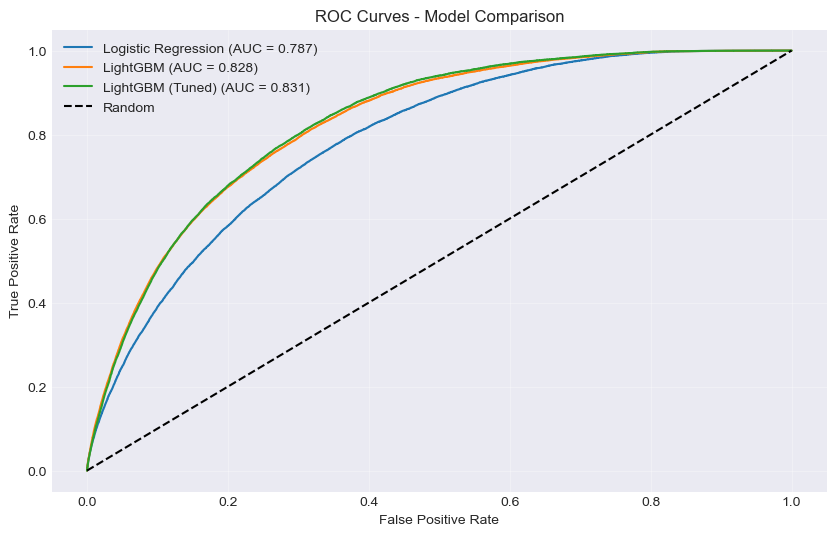


Model Evaluation completed in 0.35 seconds


In [183]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
for model_name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['predictions'])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {results['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

section_end = print_section_time("Model Evaluation", section_start)

## 7. Credit Scorecard Creation

In [185]:
section_start = time.time()

# Scorecard parameters
PDO = 20  # Points to Double the Odds
BASE_SCORE = 600  # Base score
BASE_ODDS = 50  # Good:Bad odds at base score

# Calculate scaling factor
factor = PDO / np.log(2)
offset = BASE_SCORE - factor * np.log(BASE_ODDS)

# Calculate scores
X_all = df[woe_features]
log_odds = lr_model.intercept_[0] + np.dot(X_all, lr_model.coef_[0])
df['credit_score'] = offset - factor * log_odds

print(f"Credit Score Statistics:")
print(df['credit_score'].describe())

Credit Score Statistics:
count   869263.0000
mean       587.7666
std         54.5046
min        454.8762
25%        550.3585
50%        573.6006
75%        608.6917
max        779.7124
Name: credit_score, dtype: float64


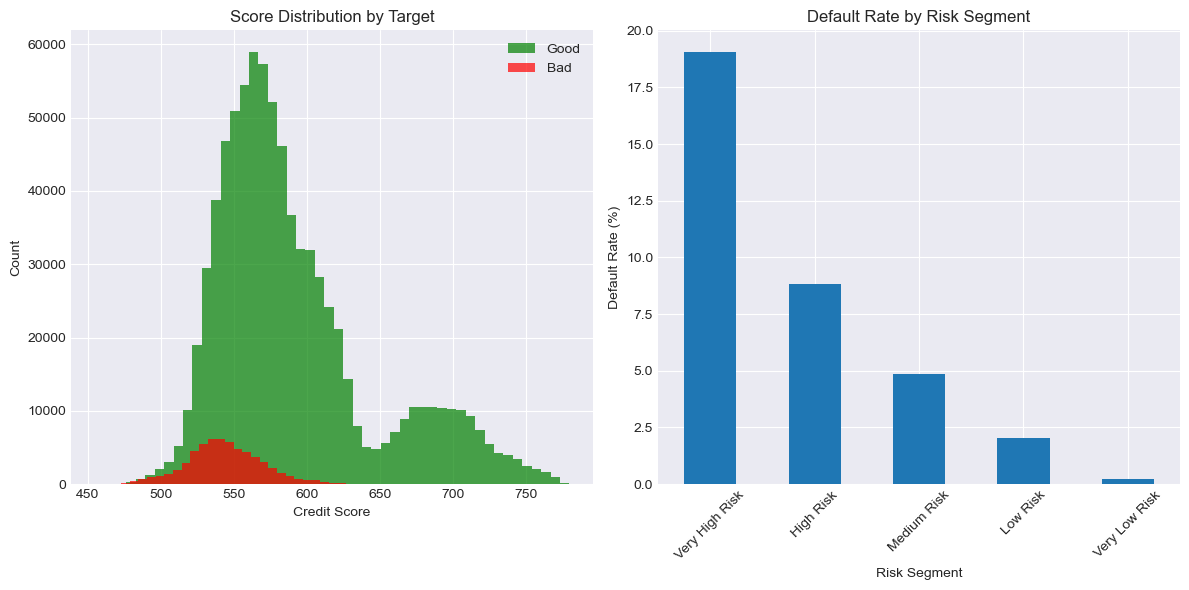


Credit Scorecard Creation completed in 2.02 seconds


In [186]:
# Score distribution by target
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df[df['target'] == 0]['credit_score'].hist(bins=50, alpha=0.7, label='Good', color='green')
df[df['target'] == 1]['credit_score'].hist(bins=50, alpha=0.7, label='Bad', color='red')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.title('Score Distribution by Target')
plt.legend()

# Risk segments
plt.subplot(1, 2, 2)
score_bins = pd.qcut(df['credit_score'], 5, labels=['Very High Risk', 'High Risk', 'Medium Risk', 'Low Risk', 'Very Low Risk'])
risk_analysis = pd.crosstab(score_bins, df['target'], normalize='index') * 100
risk_analysis[1].plot(kind='bar')
plt.xlabel('Risk Segment')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate by Risk Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

section_end = print_section_time("Credit Scorecard Creation", section_start)

## 8. Business Impact Analysis

In [193]:
section_start = time.time()

# Risk segmentation analysis
df['risk_segment'] = pd.qcut(df['credit_score'], 5, 
                             labels=['Very High Risk', 'High Risk', 'Medium Risk', 'Low Risk', 'Very Low Risk'])

segment_analysis = df.groupby('risk_segment').agg({
    'credit_score': ['mean', 'min', 'max'],
    'target': ['count', 'sum', 'mean']
}).round(3)

segment_analysis.columns = ['Avg_Score', 'Min_Score', 'Max_Score', 'Total_Loans', 'Defaults', 'Default_Rate']

print("RISK SEGMENTATION ANALYSIS:")
print(segment_analysis)

RISK SEGMENTATION ANALYSIS:
                Avg_Score  Min_Score  Max_Score  Total_Loans  Defaults  \
risk_segment                                                             
Very High Risk   530.4100   454.8760   545.3040       173853     33140   
High Risk        555.1310   545.3040   564.4260       173852     15340   
Medium Risk      573.8580   564.4260   584.3600       173853      8437   
Low Risk         600.3830   584.3600   619.8930       173853      3578   
Very Low Risk    679.0510   619.8930   779.7120       173852       405   

                Default_Rate  
risk_segment                  
Very High Risk        0.1910  
High Risk             0.0880  
Medium Risk           0.0490  
Low Risk              0.0210  
Very Low Risk         0.0020  


In [195]:
# Economic impact calculation
avg_loan_amount = 15000  # Assumed average loan amount
lgd = 0.45  # Loss Given Default

# Current state
total_loans = len(df)
total_portfolio = total_loans * avg_loan_amount
current_default_rate = df['target'].mean()
current_expected_loss = total_portfolio * current_default_rate * lgd

# With model (reject bottom 20%)
acceptance_threshold = df['credit_score'].quantile(0.2)
accepted_loans = df[df['credit_score'] > acceptance_threshold]
model_default_rate = accepted_loans['target'].mean()
model_portfolio = len(accepted_loans) * avg_loan_amount
model_expected_loss = model_portfolio * model_default_rate * lgd

In [199]:
print(f"\nECONOMIC IMPACT ANALYSIS:")
print(f"Current Portfolio: ${total_portfolio:,.0f}")
print(f"Current Expected Loss: ${current_expected_loss:,.0f} ({current_default_rate:.2%} default rate)")
print(f"\nModel-Based Portfolio: ${model_portfolio:,.0f}")
print(f"Model Expected Loss: ${model_expected_loss:,.0f} ({model_default_rate:.2%} default rate)")
print(f"\nExpected Loss Reduction: ${current_expected_loss - model_expected_loss:,.0f}")
print(f"Relative Improvement: {((current_expected_loss - model_expected_loss) / current_expected_loss):.1%}")

section_end = print_section_time("Business Impact Analysis", section_start)


ECONOMIC IMPACT ANALYSIS:
Current Portfolio: $13,089,990,000
Current Expected Loss: $412,938,000 (7.01% default rate)

Model-Based Portfolio: $10,431,150,000
Model Expected Loss: $187,380,000 (3.99% default rate)

Expected Loss Reduction: $225,558,000
Relative Improvement: 54.6%

Business Impact Analysis completed in 4.54 seconds


## 9. Production Deployment Guide

### 9.1 Model Export

In [202]:
section_start = time.time()

# Create deployment package
deployment_package = {
    'model': lr_model,
    'features': woe_features,
    'woe_mappings': {},  # Would include actual WOE mappings
    'scorecard_params': {
        'PDO': PDO,
        'BASE_SCORE': BASE_SCORE,
        'BASE_ODDS': BASE_ODDS,
        'factor': factor,
        'offset': offset
    },
    'performance_metrics': {
        'auc': lr_auc,
        'ks_statistic': ks_statistic,
        'gini_coefficient': gini_coefficient
    },
    'thresholds': {
        'high_risk': df['credit_score'].quantile(0.2),
        'medium_risk': df['credit_score'].quantile(0.5),
        'low_risk': df['credit_score'].quantile(0.8)
    }
}

print("DEPLOYMENT PACKAGE SUMMARY:")
print(f"Model Type: Logistic Regression")
print(f"Features: {len(woe_features)}")
print(f"Performance: AUC={lr_auc:.3f}, KS={ks_statistic:.3f}")
print(f"\nRisk Thresholds:")
for risk_level, threshold in deployment_package['thresholds'].items():
    print(f"  {risk_level}: < {threshold:.0f}")

# Save model (uncomment to actually save)
# import joblib
# joblib.dump(deployment_package, 'credit_risk_model_v1.pkl')

section_end = print_section_time("Production Deployment Guide", section_start)

DEPLOYMENT PACKAGE SUMMARY:
Model Type: Logistic Regression
Features: 30
Performance: AUC=0.787, KS=0.424

Risk Thresholds:
  high_risk: < 545
  medium_risk: < 574
  low_risk: < 620

Production Deployment Guide completed in 0.06 seconds


### 9.2 Monitoring Framework

In [204]:
print("MONITORING FRAMEWORK:")
print("\nKey Metrics to Track:")
monitoring_metrics = [
    "1. Model Performance: AUC, KS statistic (monthly)",
    "2. Population Stability Index (PSI) for score distribution",
    "3. Feature drift monitoring for all input variables",
    "4. Business metrics: approval rate, default rate, portfolio yield",
    "5. Regulatory compliance: fair lending metrics"
]
for metric in monitoring_metrics:
    print(f"  {metric}")

print("\nRecommended Refresh Schedule:")
print("  • Monthly: Performance monitoring report")
print("  • Quarterly: Full model validation")
print("  • Annually: Model retraining and recalibration")
print("  • Ad-hoc: Major economic events or regulatory changes")

MONITORING FRAMEWORK:

Key Metrics to Track:
  1. Model Performance: AUC, KS statistic (monthly)
  2. Population Stability Index (PSI) for score distribution
  3. Feature drift monitoring for all input variables
  4. Business metrics: approval rate, default rate, portfolio yield
  5. Regulatory compliance: fair lending metrics

Recommended Refresh Schedule:
  • Monthly: Performance monitoring report
  • Quarterly: Full model validation
  • Annually: Model retraining and recalibration
  • Ad-hoc: Major economic events or regulatory changes


## Summary and Total Execution Time

In [207]:
total_time = time.time() - notebook_start_time
print(f"\n🏁 NOTEBOOK EXECUTION COMPLETE")
print(f"Total execution time: {total_time:.2f} seconds ({total_time/60:.1f} minutes)")

print("\nFinal Model Summary:")
print(f"  • Model: Logistic Regression with WOE transformation")
print(f"  • Features: {len(woe_features)} (selected from {df.shape[1]-1} original features)")
print(f"  • Performance: AUC={lr_auc:.3f}, KS={ks_statistic:.3f}, Gini={gini_coefficient:.3f}")
print(f"  • Business Impact: {((current_expected_loss - model_expected_loss) / current_expected_loss):.0%} expected loss reduction")
print(f"  • Status: Ready for A/B testing and gradual rollout")


🏁 NOTEBOOK EXECUTION COMPLETE
Total execution time: 1590.85 seconds (26.5 minutes)

Final Model Summary:
  • Model: Logistic Regression with WOE transformation
  • Features: 30 (selected from 181 original features)
  • Performance: AUC=0.787, KS=0.424, Gini=0.575
  • Business Impact: 55% expected loss reduction
  • Status: Ready for A/B testing and gradual rollout
